In [2]:
import copy
import csv
import cvxpy
import datetime
import json
import math
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from typing import List, Dict
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
sys.path.append('../')

from skyburst import Job
from skyburst.plot import *
from skyburst.traces import philly
from skyburst.traces import philly_utils

# NUM_GPUS per node: 8
GPUS_PER_NODE = 8

def load_logs(file_path: str):
    file = open(file_path)
    return pickle.load(file)

In [23]:
def create_results_df(simulator_results: dict):
    results_df = pd.DataFrame({'alg': pd.Series(dtype='str'),
                   'input_rate': pd.Series(dtype='int'),
                   'cost': pd.Series(dtype='float'),
                   'waiting_time': pd.Series(dtype='float')})
    algs = []
    num_nodes_list = []
    cloud_costs = []
    waiting_times = []
    for key, finished_jobs in simulator_results.items():
        token_list = key.split('-')
        if len(token_list)>0:
            alg =  '-'.join(token_list[:-1])
            input_rate = token_list[-1]
        else:
            alg = f'{token_list[0]}-{token_list[1]}'
            input_rate = token_list[2]
        input_rate = int(input_rate)
        cloud_cost = 0.0
        total_waiting_time = 0.0
        count = 0
        for idx in range(len(finished_jobs['idx'])):
            if idx < 5000 or idx > len(finished_jobs['idx']) - 5000:
                continue
            arrival = finished_jobs['arrival'][idx]
            start = finished_jobs['start'][idx]
            if finished_jobs['state'][idx] != 'LOCAL':
                runtime = finished_jobs['runtime'][idx]
                cloud_cost += finished_jobs['num_gpus'][idx] * runtime
                if finished_jobs['state'][idx] == 'FILTER-CLOUD':
                    total_waiting_time += start - arrival
                else:
                    deadline = finished_jobs['deadline'][idx]
                    total_waiting_time += deadline - runtime - arrival
            else:
                total_waiting_time += start - arrival
            count+=1
        avg_waiting_time = total_waiting_time / count
        df = pd.DataFrame(data={'alg': [alg], 'input_rate': [input_rate], 'cost': [cloud_cost], 'waiting_time': [avg_waiting_time]})
        results_df = pd.concat([results_df, df], ignore_index=True)
    return results_df

def plot_cost_and_waiting_graph(results_df, normalized=False, plot_twin=True):
#     options = ['fifo', 'lifo', 'lifo-nohol']
#     results_df = results_df[results_df['alg'].isin(options)]
    if plot_twin:
        fig, ax = plt.subplots()
        ax2 = ax.twinx()
    else:
        # Get current default figsize
        default_figsize = plt.rcParams.get('figure.figsize')
        # Set the new figsize as the default
        fix, (ax, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(2*default_figsize[0], 2*default_figsize[1]))

    x_axis = 'normalized_input_rate'
    results_df['normalized_input_rate'] = results_df['input_rate']*1.3231333333333333/64
    label_x = 'Normalized Input Rate'
    
    for idx, (label, grp) in enumerate(results_df.groupby('alg')):
        a1 = grp.plot(x = x_axis, y = 'cost',ax = ax, marker='^', label = label, legend=None, xlabel=label_x, \
                ylabel='Cloud Price')
        if plot_twin:
            style = '--'
        else:
            style = None
        a2 = grp.plot(x = x_axis, y = 'waiting_time', ax = ax2, marker='v', label = label, legend=None, xlabel=label_x, \
                      ylabel = 'Avg. Waiting Time', style=style)
    ax.set_ylim(bottom=0.0)
    
    if plot_twin:
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, ncol=len(labels) + len(labels2), \
                  bbox_to_anchor=(0, 1.00, 1, 0.2), loc="upper left")
        ax.grid(True, which='both')
    else:
        lines, labels = ax.get_legend_handles_labels()
        ax.legend(lines, labels, ncol=len(labels), \
                  bbox_to_anchor=(0, 0.90, 1, 0.2), loc="upper left")
        ax.grid(True, which='both')
        ax2.grid(True, which='both')
    plt.show()  

In [22]:

results={}
hybrid_results_df = pd.DataFrame()
for ddl in [1, 1.25]:
    num_nodes = 64
    file = open(f'logs/poisson/linear_cap/vjw_philly_{ddl}_cont.log', 'rb')
    results[ddl] = pickle.load(file)
    temp_df = create_results_df(results[ddl])
    temp_df['deadline'] = ddl
    plot_cost_and_waiting_graph(temp_df, normalized=False, plot_twin=False)
    hybrid_results_df = pd.concat([hybrid_results_df, temp_df], ignore_index=True)

KeyboardInterrupt: 

In [26]:
avg_job_volume_rate = np.mean(results[1.25]['fifo-16']['num_gpus']* results[1.25]['fifo-16']['runtime'])
print(avg_job_volume_rate)

print(np.mean(results[1.25]['fifo-16']['num_gpus']))

print(np.mean(results[1.25]['fifo-16']['runtime']))

13.580799152777779
1.3252916666666668
3.960832476851852


['fifo-backfill', 'swf-backfill', 'lvjf-backfill', 'svjf-backfill', 'lifo-backfill', 'fifo']


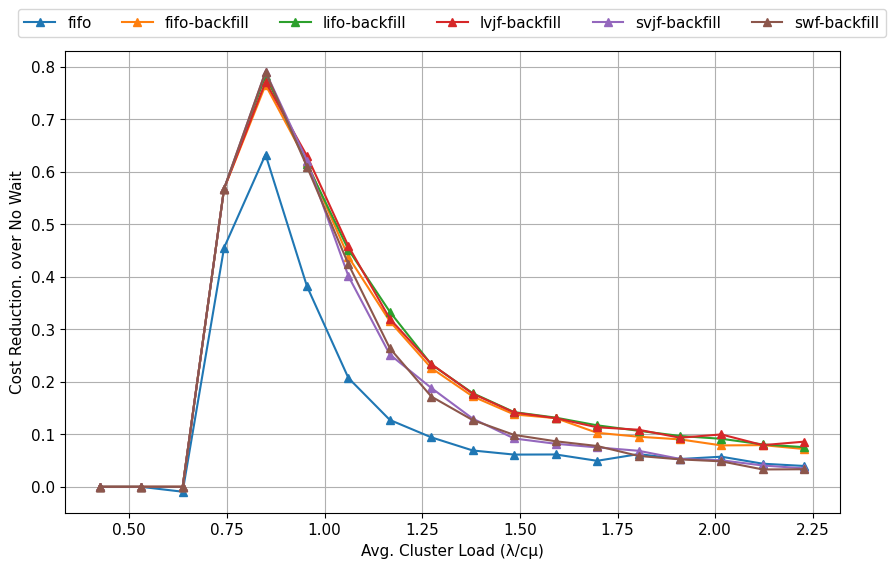

In [41]:
def plot_normalized_cost_deadline(results_df):
    fig, ax = plt.subplots(figsize=(10, 6))
    #fig, ax = plt.subplots()
    results_df['normalized_input_rate'] = results_df['input_rate']* avg_job_volume_rate/(64*8)
    baseline_df =  results_df[results_df['deadline']==1]
    baseline_df = baseline_df[baseline_df['alg']=='fifo']
    #results_df[results_df['alg']=='fifo']
    
    options = ['fifo', 'swf', 'lvjf', 'svjf', 'lifo']
    
    options = [o + '-backfill' for o in options]
#     options.append('swf')
    options.append('fifo')
#     options.append('lifo')
    #options.remove('fifo-nohol')
    print(options)
    results_df = results_df[results_df['alg'].isin(options)]
    results_df = results_df[results_df['deadline']==1.25]
    
    #results_df = results_df[results_df['alg']!='fifo']
    
    diff_df = pd.merge(baseline_df,
               results_df, left_on=['input_rate', 'normalized_input_rate'],right_on=['input_rate', 'normalized_input_rate'])
    
    def cost_multiplier(row):
        baseline_cost = row['cost_x']
        cost = row['cost_y']
        
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost==0:
            return 1
        return 1 - (cost/baseline_cost)
    
    diff_df['cost_diff'] = diff_df.apply(cost_multiplier, axis=1)
    
#     diff_df['cost_diff'] = (diff_df['cost_x'] - diff_df['cost_y'])#/diff_df['cost_x']
    plt.rcParams.update({'font.size': 11})
    for idx, (label, grp) in enumerate(diff_df.groupby('alg_y')):
        a1 = grp.plot(x = 'normalized_input_rate', y = 'cost_diff',ax = ax, marker='^', label = label, legend=None, xlabel='Avg. Cluster Load (λ/cμ)', \
                ylabel='Cost Reduction. over No Wait')
    lines, labels = ax.get_legend_handles_labels()
    #plt.xlim(left=0.46)
    #plt.ylim(bottom=-0.25, top = 0.6)
    ax.legend(lines, labels, ncol=len(labels), \
              bbox_to_anchor=(0, 0.96, 1, 0.2), loc="center")
    ax.grid(True, which='both')
    plt.show()


plot_normalized_cost_deadline(hybrid_results_df)

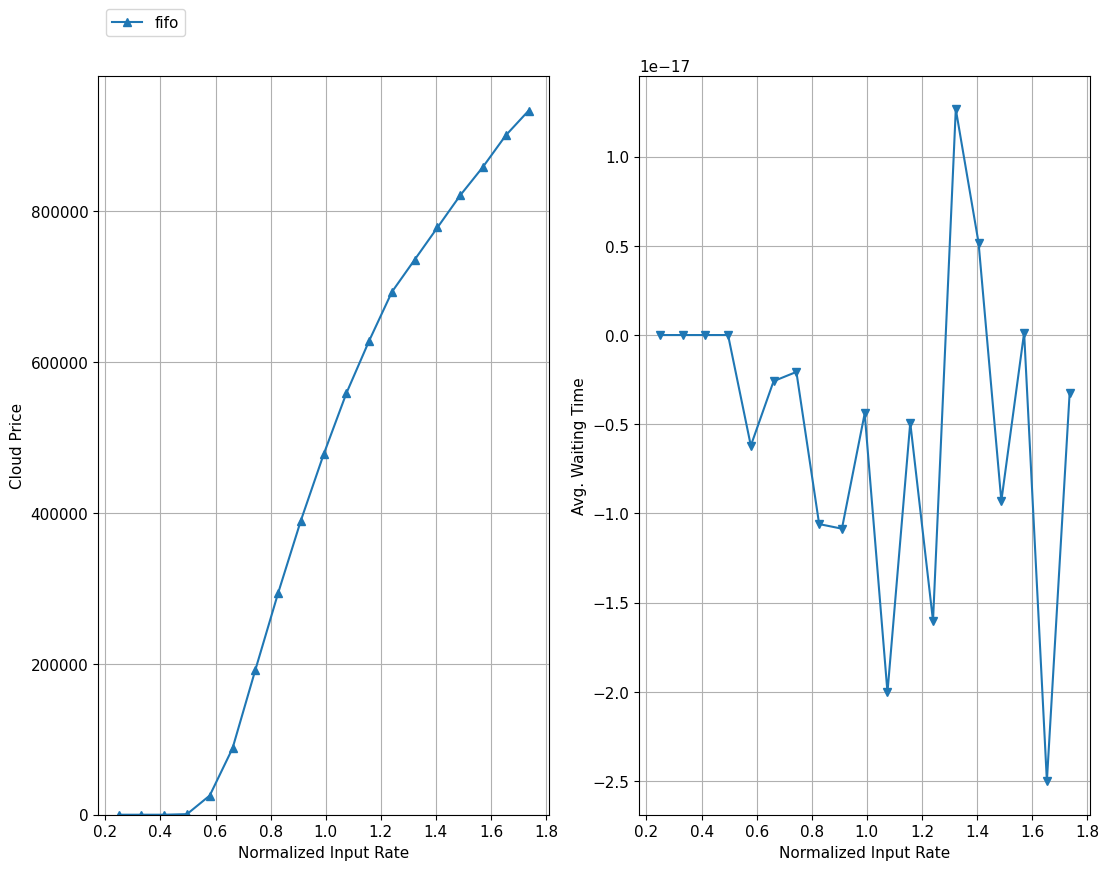

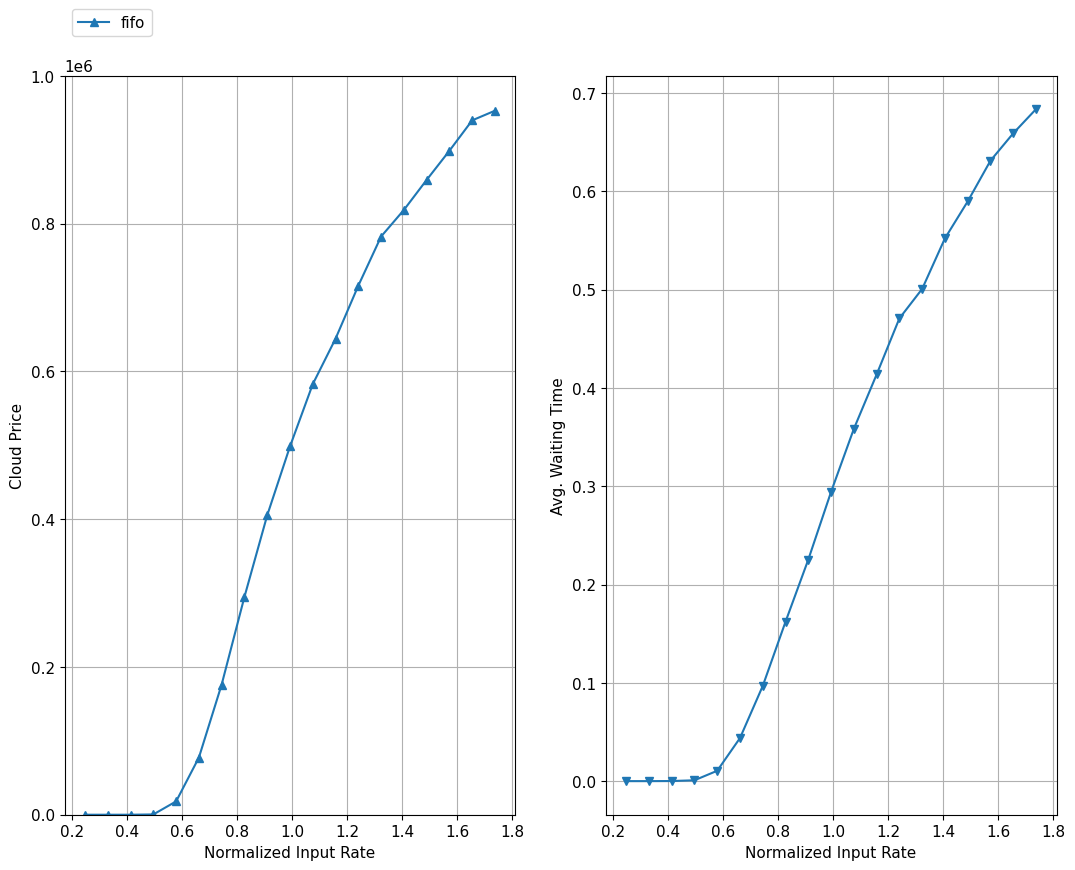

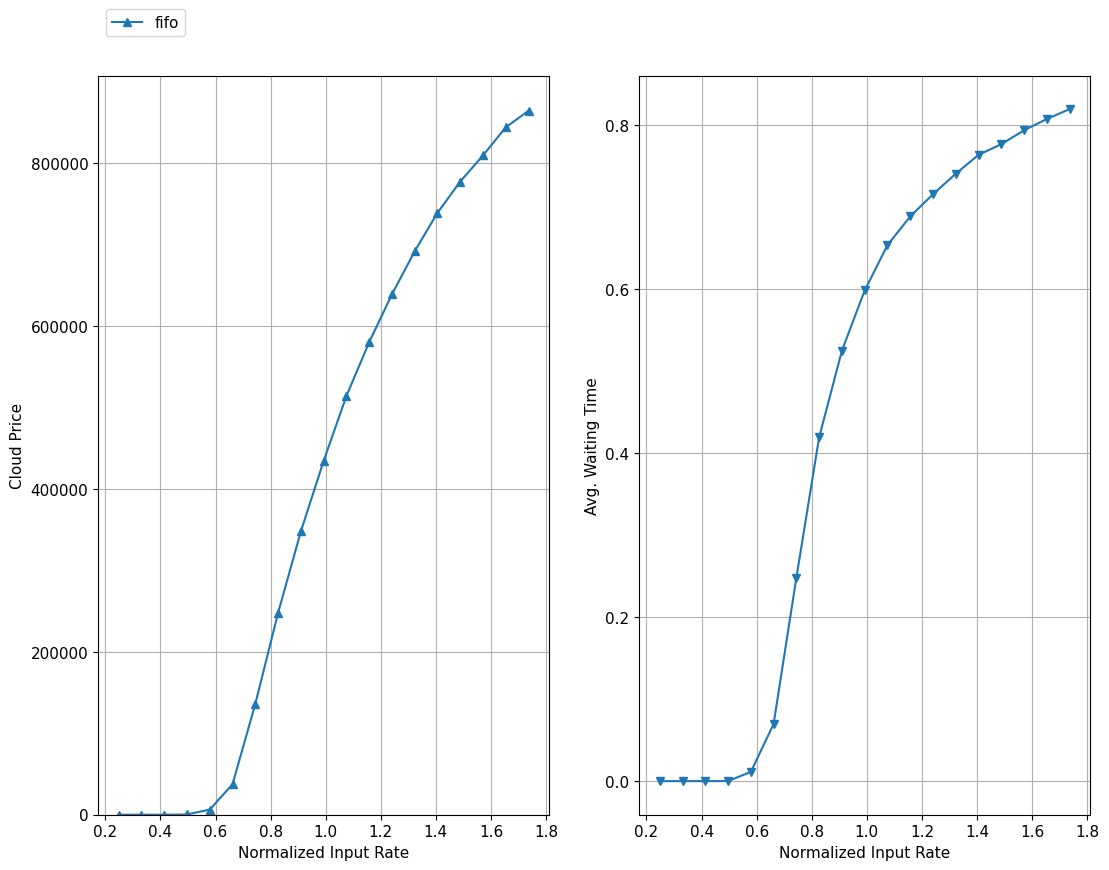

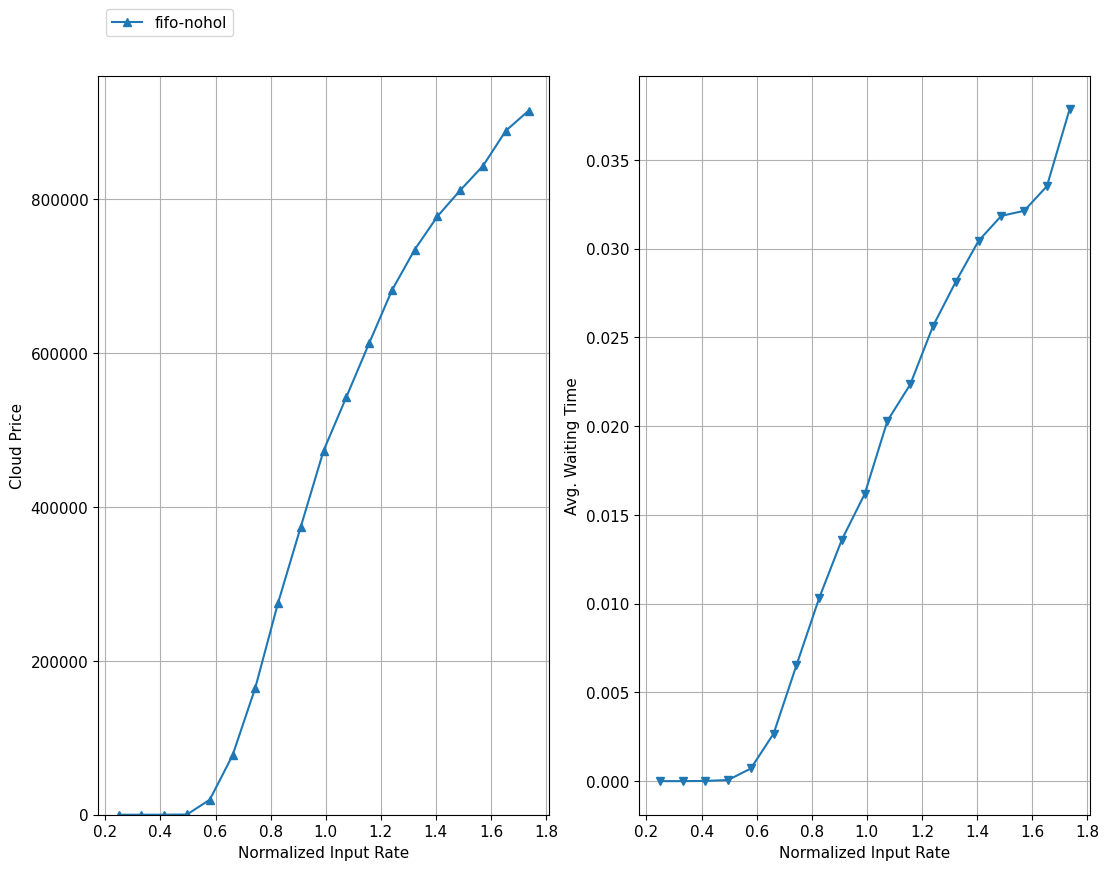

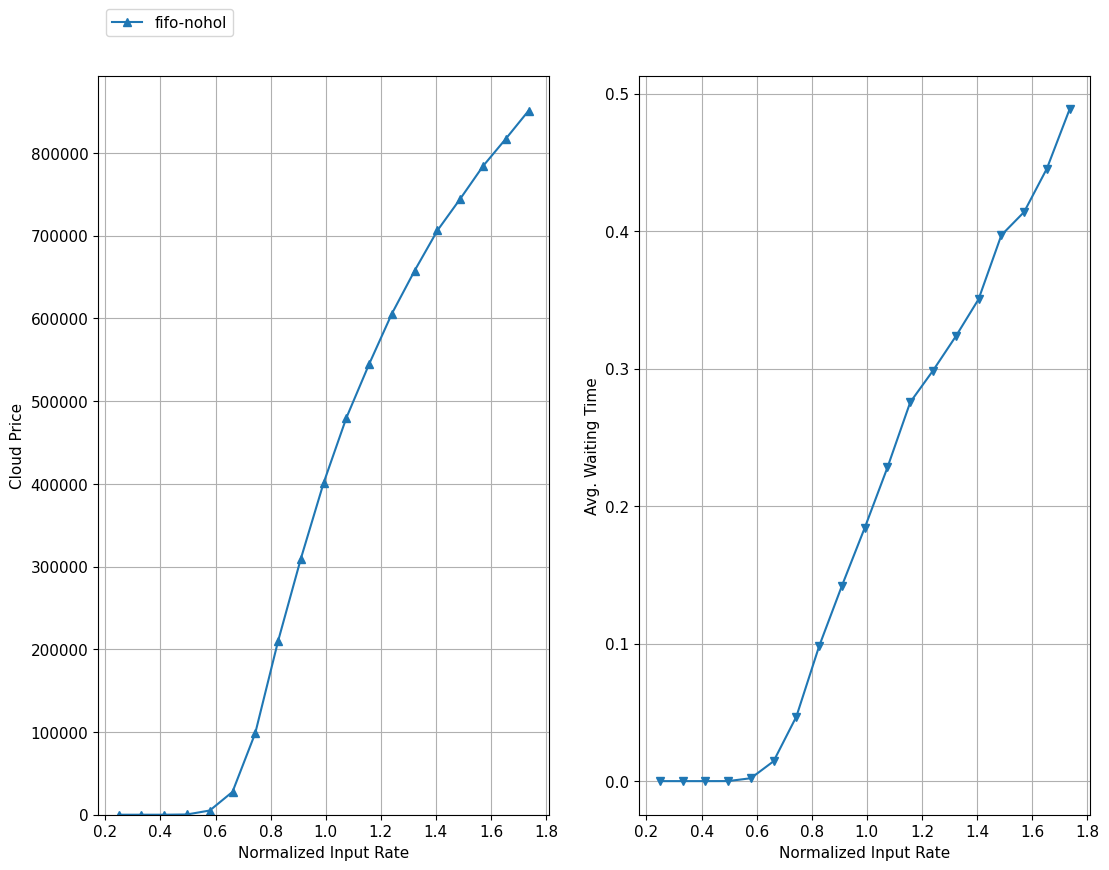

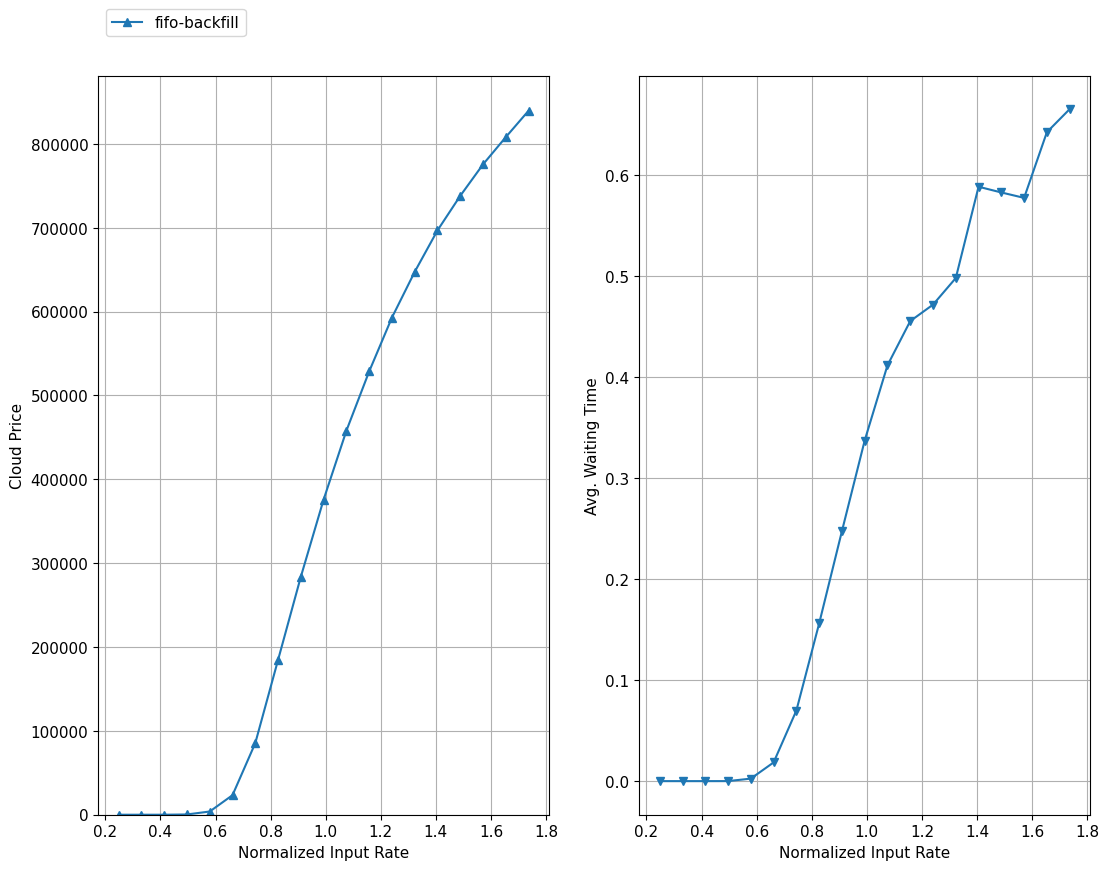

In [32]:
results={}
hybrid_results_df = pd.DataFrame()
for ddl in ['nowait', 'constant', 'linear', 'constant-nohol', 'linear-nohol', 'linear-backfill']:
    num_nodes = 64
    file = open(f'logs/poisson/build/{ddl}.log', 'rb')
    results[ddl] = pickle.load(file)
    temp_df = create_results_df(results[ddl])
    temp_df['deadline'] = ddl
    plot_cost_and_waiting_graph(temp_df, normalized=False, plot_twin=False)
    hybrid_results_df = pd.concat([hybrid_results_df, temp_df], ignore_index=True)

In [33]:
avg_job_volume_rate = np.mean(results['nowait']['fifo-16']['num_gpus']* results['nowait']['fifo-16']['runtime'])
print(avg_job_volume_rate)

14.244234870370368


    alg_x  input_rate         cost_x  waiting_time_x deadline_x  \
0    fifo          12       0.000000    0.000000e+00     nowait   
1    fifo          12       0.000000    0.000000e+00     nowait   
2    fifo          12       0.000000    0.000000e+00     nowait   
3    fifo          12       0.000000    0.000000e+00     nowait   
4    fifo          12       0.000000    0.000000e+00     nowait   
..    ...         ...            ...             ...        ...   
109  fifo          84  932913.762222   -3.229710e-18     nowait   
110  fifo          84  932913.762222   -3.229710e-18     nowait   
111  fifo          84  932913.762222   -3.229710e-18     nowait   
112  fifo          84  932913.762222   -3.229710e-18     nowait   
113  fifo          84  932913.762222   -3.229710e-18     nowait   

     normalized_input_rate          alg_y         cost_y  waiting_time_y  \
0                 0.333849           fifo       0.000000        0.000000   
1                 0.333849           fifo  

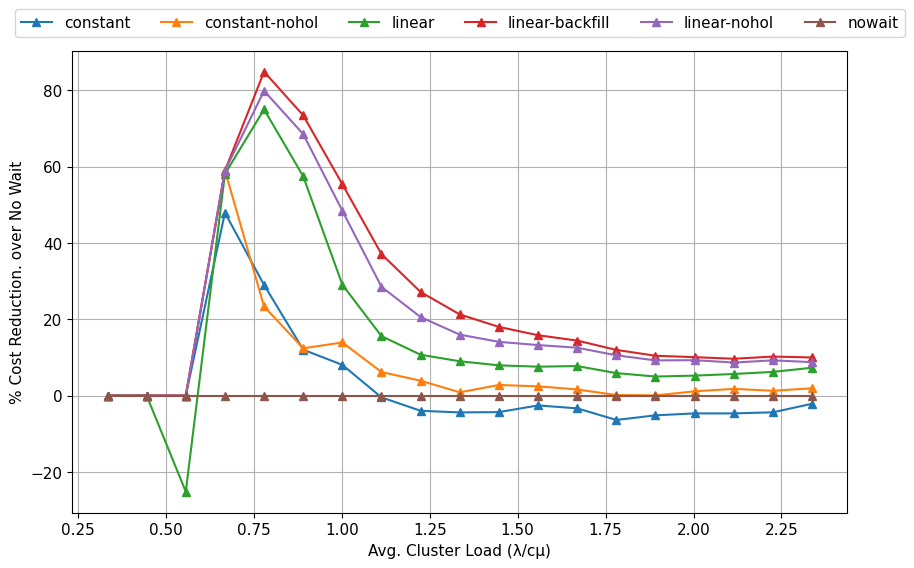

In [39]:
def plot_starburst(results_df):
    fig, ax = plt.subplots(figsize=(10, 6))
    #fig, ax = plt.subplots()
    results_df['normalized_input_rate'] = results_df['input_rate']* avg_job_volume_rate/(64*8)
    baseline_df =  results_df[results_df['deadline']=='nowait']
    #results_df[results_df['alg']=='fifo']
    
    #options = ['nowait', 'constant-nohol', 'linear-backfill']
    #results_df = results_df[results_df['deadline'].isin(options)]
#     results_df = results_df[results_df['deadline']==1.25]
    
    #results_df = results_df[results_df['alg']!='fifo']
    
    diff_df = pd.merge(baseline_df,
               results_df, left_on=['input_rate', 'normalized_input_rate'],right_on=['input_rate', 'normalized_input_rate'])
    
    def cost_multiplier(row):
        baseline_cost = row['cost_x']
        cost = row['cost_y']
        
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost==0:
            return 0
        frac = 1 - (cost/baseline_cost)
        if frac < -1:
            return -100
        return 100 * frac
    
    diff_df['cost_diff'] = diff_df.apply(cost_multiplier, axis=1)
    
    print(diff_df)
#     diff_df['cost_diff'] = (diff_df['cost_x'] - diff_df['cost_y'])#/diff_df['cost_x']
    plt.rcParams.update({'font.size': 11})
    for idx, (label, grp) in enumerate(diff_df.groupby('deadline_y')):
        a1 = grp.plot(x = 'normalized_input_rate', y = 'cost_diff',ax = ax, marker='^', label = label, legend=None, xlabel='Avg. Cluster Load (λ/cμ)', \
                ylabel='% Cost Reduction. over No Wait')
    lines, labels = ax.get_legend_handles_labels()
    #plt.xlim(left=0.46)
    #plt.ylim(bottom=-0.25, top = 0.6)
    ax.legend(lines, labels, ncol=len(labels), \
              bbox_to_anchor=(0, 0.96, 1, 0.2), loc="center")
    ax.grid(True, which='both')

plot_starburst(hybrid_results_df)